In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#===================================================================================
#  PARAMETERS
#===================================================================================

az_res_scale = 1                            # values above 1 reduce resolution, but also computation time
fftsize = 4096*4                            # size of fft to use for backprojection range compression
# fftsize = 1702
N = (int)(np.ceil(fftsize/2))
c0 = 299702547                              # speed of light in the atmosphere (m/s)
actual_samples=1702                         # number of samples/chirp
PRF = 307.292                               # effective pulse repetition frequency (Hz)
azBW=0.1920                                 # 3dB antenna azimuth beamwidth (rad) (3dB to 3dB)
cabledelay = -1.2                           # system and cable delay (m)
f_adc = 24485000                            # adc sample rate (Hz)
bw = 170000000                              # transmit bandwidth (Hz)
fc = 5.42876e9                              # carrier frequency (Hz)
kr = 1.597249139246997e12                   # chirp rate
delrad = c0*f_adc/(4*kr*np.pi)              # meters per radian
delsamp = delrad*2*np.pi/actual_samples     # meters per real sample
delrsamp = delsamp*(actual_samples/fftsize) # meters per interpolated sample 
wavelength = c0/fc                          # carrier wave length
az_res = wavelength/(2*azBW)*az_res_scale   # azimuth resolution
rres = c0/(2*bw)                            # slant range resolution
a_end = 404.1059                            # ?
cable_delay = -1.2;

n_range_bins = 1702                               # number of range bins
n_pulses = 3884                               # number of pulses

max_range = c0*f_adc/(4*kr)                 # maximum range without aliasing
z = 346.8229                                # mean altitude for all platform positions [m]

In [3]:
#===================================================================================
#  DATA
#===================================================================================

### Phase History
uncompressed_data = np.fromfile('../gpu_cpp/input/casie_raw_data.bin', dtype='double')
uncompressed_data = uncompressed_data.reshape((n_pulses, n_range_bins))

Text(0.5, 1.0, 'Range Compressed Complex Data')

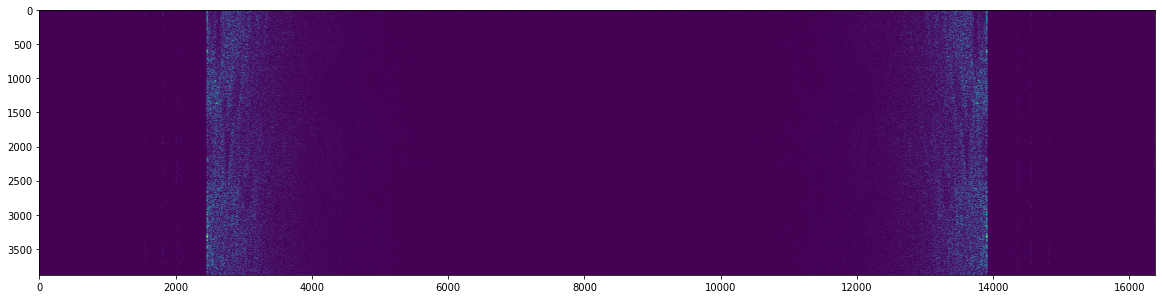

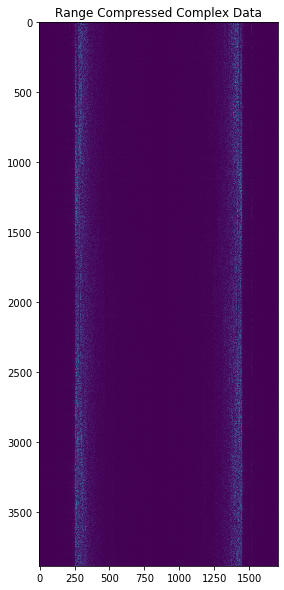

In [11]:
#===================================================================================
#  PRE-PROCESSING
#===================================================================================

### Range Compression
# Data is compressed by using a range window and zero-padding then performing an FFT.
blackman_window = np.tile(np.blackman(n_range_bins), (n_pulses, 1))
windowed_data = np.multiply(uncompressed_data, blackman_window)

# Performing 1 dimensional FFT along rows. 
range_compressed = np.fft.fft(windowed_data, n=fftsize, axis=1)

plt.figure(figsize=(20,10))
plt.imshow(abs(range_compressed))
# Discarding duplicated half of spectrum
# fftsize = len(range_compressed) # the changed one
# N = (int)(fftsize/2);
# range_compressed = np.concatenate((range_compressed[0:N, :], np.zeros((1, n_cols))))

Text(0.5, 1.0, 'Range Compressed Data From CUDA Implementation')

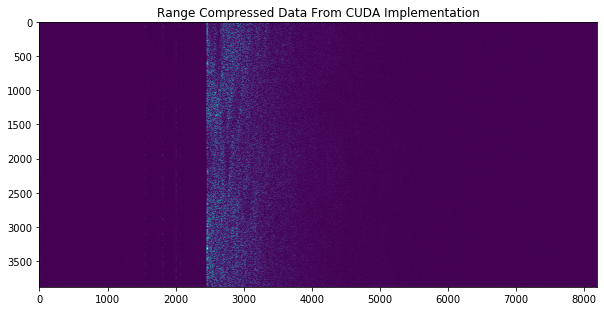

In [10]:
#===================================================================================
#  COMPARE WITH CUDA RESULT
#===================================================================================
range_compressed_cuda = np.fromfile('../gpu_cpp/output/range_compressed.bin', dtype='complex128')
range_compressed_cuda = range_compressed_cuda.reshape(3884, 8193)

plt.figure(figsize=(10,10))
plt.imshow(abs(range_compressed_cuda))
plt.title('Range Compressed Data From CUDA Implementation')

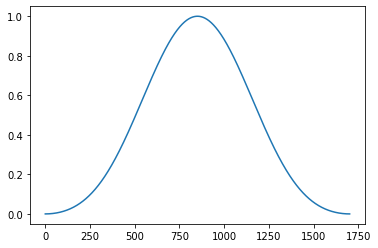

In [24]:
blackman_matrix = np.fromfile('../gpu_cpp/output/blackman_matrix.bin', dtype='complex128')
blackman_matrix = blackman_matrix.reshape(3884, 1702)

plt.plot(abs(blackman_matrix[0]))

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


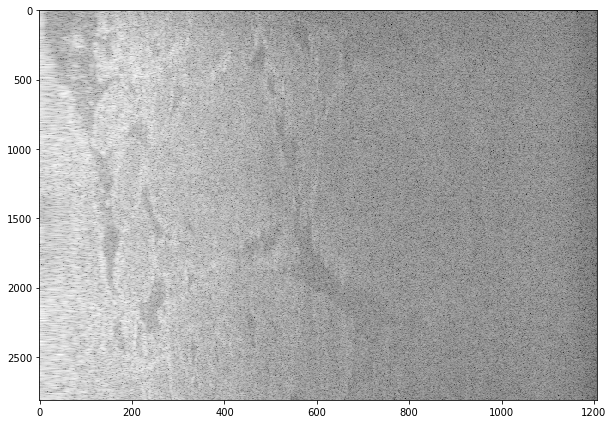

In [3]:
#===================================================================================
#  PLOT IMAGE RESULT
#===================================================================================
img_cuda = np.fromfile('../gpu_cpp/output/image.bin', dtype='complex128')
img_cuda = img_cuda.reshape(2810, 1208)

plt.figure(figsize=(10,10))
plt.imshow(20*np.log10(abs(img_cuda)), aspect=0.3, cmap='gray')
img_cuda -= np.max(img_cuda)
# img = np.clip(img, -100, 0)

# print(img_cuda)